num_cols: ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
cat_encode: ['gender']
cat_passthrough (will use frequency encoding): ['merchant', 'category', 'job']
Running baseline CV (may take a minute)...
LR CV: {'precision': np.float64(0.07183952600435897), 'recall': np.float64(0.741179859909209), 'f1': np.float64(0.13097008892517836), 'aupr': np.float64(0.19138881054596646), 'auc': np.float64(0.852314727068028)}
RF CV: {'precision': np.float64(0.8984346168826091), 'recall': np.float64(0.6482615397166717), 'f1': np.float64(0.7530154829802758), 'aupr': np.float64(0.8369731264042461), 'auc': np.float64(0.9860522971907328)}
SMOTE+RF CV: {'precision': np.float64(0.7431204327106503), 'recall': np.float64(0.777073390325344), 'f1': np.float64(0.7595900964691709), 'aupr': np.float64(0.8184926289849945), 'auc': np.float64(0.987574668239066)}
Tuning XGBoost (quick)...
XGB best params: {'clf__subsample': 0.9, 'clf__n_estimators': 100, 'clf__max_depth': 6, 'clf__learning_

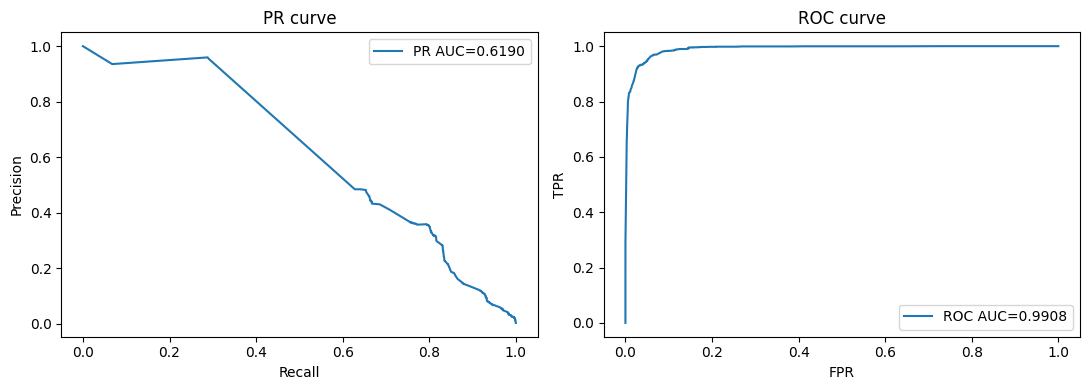

Best threshold (val) for F1: 0.8099 F1: 0.6314

Metrics at tuned threshold:
Precision: 0.4849
Recall: 0.628
F1: 0.5472
Confusion matrix:
 [[552143   1431]
 [   798   1347]]
Saved model -> best_fraud_model_freqenc.joblib


In [ ]:
# Full fixed script: uses FrequencyEncoding for high-cardinality categorical cols
# Upload fraudTrain.csv and fraudTest.csv first.

# !pip install -q imbalanced-learn xgboost

import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, average_precision_score,
                             roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

# ---------- config ----------
TRAIN_FILE = "fraudTrain.csv"
TEST_FILE  = "fraudTest.csv"
TARGET_COL = "is_fraud"

# ---------- load ----------
if not (os.path.exists(TRAIN_FILE) and os.path.exists(TEST_FILE)):
    raise FileNotFoundError("Place fraudTrain.csv and fraudTest.csv in working directory.")

train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)

# drop unlabeled rows
train_df = train_df.dropna(subset=[TARGET_COL]).reset_index(drop=True)
test_df  = test_df.dropna(subset=[TARGET_COL]).reset_index(drop=True)

# ensure int target
train_df[TARGET_COL] = train_df[TARGET_COL].astype(int)
test_df[TARGET_COL]  = test_df[TARGET_COL].astype(int)

# drop PII
drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'first', 'last',
             'street', 'city', 'state', 'zip', 'trans_num', 'dob']
drop_present = [c for c in drop_cols if c in train_df.columns]
train_df = train_df.drop(columns=drop_present)
test_df  = test_df.drop(columns=drop_present)

# build X,y
X_train = train_df.drop(columns=[TARGET_COL]).reset_index(drop=True)
y_train = train_df[TARGET_COL].reset_index(drop=True)
X_test  = test_df.drop(columns=[TARGET_COL]).reset_index(drop=True)
y_test  = test_df[TARGET_COL].reset_index(drop=True)

# detect numeric / categorical
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# choose small-cardinality to one-hot (<=10 unique)
cat_encode = [c for c in cat_cols if X_train[c].nunique() <= 10]
cat_passthrough = [c for c in cat_cols if c not in cat_encode]

print("num_cols:", num_cols)
print("cat_encode:", cat_encode)
print("cat_passthrough (will use frequency encoding):", cat_passthrough)

# ---------- FrequencyEncoder transformer ----------
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.maps_ = {}
        self.cols = None
    def fit(self, X, y=None):
        # X expected as DataFrame
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        self.cols = X.columns.tolist()
        for c in self.cols:
            vc = X[c].fillna("__NA__").astype(str).value_counts(normalize=True)
            self.maps_[c] = vc.to_dict()
        return self
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.cols)
        out = pd.DataFrame()
        for c in self.cols:
            s = X[c].fillna("__NA__").astype(str).map(self.maps_.get(c, {}))
            # unseen categories -> 0
            s = s.fillna(0.0)
            out[c+"_freq"] = s.astype(float)
        return out.values  # return numpy array for ColumnTransformer compatibility

# ---------- preprocessing ----------
num_pipe = Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())])
cat_enc_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
cat_pass_pipe = Pipeline([("freq", FrequencyEncoder()), ("impute", SimpleImputer(strategy="constant", fill_value=0.0))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat_enc", cat_enc_pipe, cat_encode),
        ("cat_pass", cat_pass_pipe, cat_passthrough)
    ],
    remainder="drop"
)

# ---------- CV eval helper ----------
def evaluate_model(pipe, X, y, folds=4):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    metrics = {"precision": [], "recall": [], "f1": [], "aupr": [], "auc": []}
    for tr_idx, va_idx in skf.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        pipe.fit(Xtr, ytr)
        prob = pipe.predict_proba(Xva)[:,1] if hasattr(pipe, "predict_proba") else pipe.decision_function(Xva)
        pred = (prob >= 0.5).astype(int)
        metrics["precision"].append(precision_score(yva, pred, zero_division=0))
        metrics["recall"].append(recall_score(yva, pred, zero_division=0))
        metrics["f1"].append(f1_score(yva, pred, zero_division=0))
        metrics["aupr"].append(average_precision_score(yva, prob))
        metrics["auc"].append(roc_auc_score(yva, prob))
    return {k: np.mean(v) for k, v in metrics.items()}

# ---------- Baselines ----------
pipe_lr = Pipeline([("pre", preprocessor),
                    ("clf", LogisticRegression(class_weight="balanced", solver="saga", max_iter=2000, random_state=42))])
pipe_rf = Pipeline([("pre", preprocessor),
                    ("clf", RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1, random_state=42))])

print("Running baseline CV (may take a minute)...")
print("LR CV:", evaluate_model(pipe_lr, X_train, y_train))
print("RF CV:", evaluate_model(pipe_rf, X_train, y_train))

# ---------- SMOTE + RF (optional) ----------
pipe_smote_rf = ImbPipeline([("pre", preprocessor), ("smote", SMOTE(random_state=42)), ("clf", RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42))])
print("SMOTE+RF CV:", evaluate_model(pipe_smote_rf, X_train, y_train))

# ---------- XGBoost with scale_pos_weight and light tuning ----------
neg = (y_train==0).sum(); pos = (y_train==1).sum()
scale = neg/pos if pos>0 else 1.0
pipe_xgb = Pipeline([("pre", preprocessor), ("clf", xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale, random_state=42, n_jobs=-1))])

param_dist = {"clf__n_estimators":[100,200], "clf__max_depth":[3,6], "clf__learning_rate":[0.01,0.1], "clf__subsample":[0.6,0.9]}
rs = RandomizedSearchCV(pipe_xgb, param_dist, n_iter=4, scoring="average_precision", cv=3, n_jobs=-1, random_state=42, verbose=0)
print("Tuning XGBoost (quick)...")
rs.fit(X_train, y_train)
print("XGB best params:", rs.best_params_, "best AUPR:", rs.best_score_)
best_model = rs.best_estimator_

# ---------- Final eval on provided test set ----------
best_model.fit(X_train, y_train)
probs_test = best_model.predict_proba(X_test)[:,1]
preds_test = (probs_test >= 0.5).astype(int)

print("\nClassification report (threshold 0.5):")
print(classification_report(y_test, preds_test, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, preds_test))
print("Test AUPR:", round(average_precision_score(y_test, probs_test),4))
print("Test ROC AUC:", round(roc_auc_score(y_test, probs_test),4))

# ---------- PR and ROC plots ----------
prec, rec, thr = precision_recall_curve(y_test, probs_test)
pr_auc = auc(rec, prec)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, probs_test)
plt.figure(figsize=(11,4))
plt.subplot(1,2,1); plt.plot(rec, prec, label=f"PR AUC={pr_auc:.4f}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR curve"); plt.legend()
plt.subplot(1,2,2); plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_score(y_test, probs_test):.4f}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve"); plt.legend()
plt.tight_layout(); plt.show()

# ---------- Threshold tuning ----------
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=1)
best_model.fit(X_tr_sub, y_tr_sub)
pval = best_model.predict_proba(X_val_sub)[:,1]
ths = np.linspace(0.01,0.9,80); best_f1=0; best_t=0.5
for t in ths:
    f = f1_score(y_val_sub, (pval>=t).astype(int), zero_division=0)
    if f>best_f1:
        best_f1=f; best_t=t
print("Best threshold (val) for F1:", round(best_t,4), "F1:", round(best_f1,4))

preds_test_thr = (probs_test >= best_t).astype(int)
print("\nMetrics at tuned threshold:")
print("Precision:", round(precision_score(y_test, preds_test_thr, zero_division=0),4))
print("Recall:", round(recall_score(y_test, preds_test_thr, zero_division=0),4))
print("F1:", round(f1_score(y_test, preds_test_thr, zero_division=0),4))
print("Confusion matrix:\n", confusion_matrix(y_test, preds_test_thr))

# ---------- Save ----------
joblib.dump(best_model, "best_fraud_model_freqenc.joblib")
print("Saved model -> best_fraud_model_freqenc.joblib")
